# Positron emission tomography (PET) data realignment example

This example shows how to estimate the head motion of a PET dataset using `NiFreeze`.

The notebook uses the `sub-02` dataset that was generated synthetically from
a real PET dataset by adding random motion. The dataset can be installed from
[GIN G-node](https://gin.g-node.org/nipreps-data/tests-nifreeze):

```
$ datalad install -g https://gin.g-node.org/nipreps-data/tests-nifreeze.git
```

after which the environment variable `TEST_DATA_HOME` will need to be set to
point to the corresponding folder.

In [3]:
from os import getenv
from pathlib import Path

from nifreeze.data.pet import from_nii

# Install test data from gin.g-node.org:
#   $ datalad install -g https://gin.g-node.org/nipreps-data/tests-nifreeze.git
# and point the environment variable TEST_DATA_HOME to the corresponding folder
DATA_PATH = Path(getenv("TEST_DATA_HOME", str(Path.home() / "nifreeze-tests")))
WORKDIR = Path.home() / "tmp" / "nifreezedev" / "pet_data"
WORKDIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = WORKDIR / "motion_estimation"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

pet_file = (
    DATA_PATH / "pet_data" / "sub-02" / "ses-baseline" / "pet" / "sub-02_ses-baseline_pet.nii.gz"
)
json_file = (
    DATA_PATH / "pet_data" / "sub-02" / "ses-baseline" / "pet" / "sub-02_ses-baseline_pet.json"
)

pet_dataset = from_nii(pet_file, temporal_file=json_file)

Let's first preprocess the data: we will smooth and threshold them.

In [4]:
import nibabel as nb
import numpy as np
from nibabel.processing import smooth_image

smooth_fwhm = 10.0
thresh_pct = 20.0

pet_img = nb.load(pet_file)
pet_dataobj = pet_img.get_fdata()

smoothed_img = smooth_image(nb.Nifti1Image(pet_dataobj, pet_img.affine), smooth_fwhm)
thresh_val = np.percentile(smoothed_img.get_fdata(), thresh_pct)
pet_dataobj[pet_dataobj < thresh_val] = 0

preproc_pet_img_file = WORKDIR / "sub-02_ses-baseline_pet_desc-preproc.nii.gz"

nb.save(nb.Nifti1Image(pet_dataobj, pet_img.affine), preproc_pet_img_file)

We will now create the PET dataset object.

In [5]:
pet_dataset = from_nii(preproc_pet_img_file, temporal_file=json_file)

pet_dataset

PET(dataobj=<128x128x90x21 (float64)>, affine=<4x4 (float64)>, brainmask=None, motion_affines=None, datahdr=None, midframe=<21 (float64)>, total_duration=7200.066)

In [4]:
data_train, data_test = pet_dataset.lofo_split(15)

In [5]:
data_train[0]

array([[[[-0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0., -0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[-0.,  0.,  0., ...,  0., -0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ..., -0., -0.,  0.],
         ...,
         [ 0.,  0., -0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ..., -0.,  0.,  0.],
         [-0.,  0., -0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [-0., -0., -0., ...,  0., -0.,  0.],
         [-0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0., -0.,  0., ..., -0.,  0.,  0.],
         [-0.,  0., -0., ...,  0.,  0.,  0.],
         [-0., -0.,  0., ..., -0.,  0.,  0.]],

        ...,

        [[-0.,  0.,  0., ...,  0.,  0.,  0.],
         [-0.,  0.,  0., ...,  0., -0.,  0.],
         [-0.,  0.

## Model fitting and motion correction

The relevant structure to model PET data is `nifreeze.model.BSplinePETModel`. We
instantiate it by providing it with the loaded PET dataset.

In [5]:
from nifreeze.model import BSplinePETModel

model = BSplinePETModel(dataset=pet_dataset)

/Users/martinnorgaard/Dropbox/Mac/Documents/GitHub/nifreeze/src/nifreeze/model/pet.py:82: UserWarning: No mask provided; consider using a mask to avoid issues in model optimization.
  super().__init__(dataset, **kwargs)


In [6]:
model.fit_predict(None)

Let's now ask the model for a prediction at the time point pointed by the
index value `2`. By calling `model.fit_predict` the model is fitted using all
the available data, and a prediction is requested on the time provided as the
argument. The B-Spline PET model employs uses a B-Spline-based interpolation
method to estimate the data for the requested frame.

In [7]:
index = 2
predicted = model.fit_predict(index)

We now save the uncorrected and corrected data so that we can visualize the
difference.

In [8]:
import nibabel as nb

# before
nifti_img_before = nb.Nifti1Image(pet_dataset[index][0], pet_dataset.affine)
output_path_before = "before_mc.nii"
nifti_img_before.to_filename(output_path_before)

# after
nifti_img_after = nb.Nifti1Image(predicted, pet_dataset.affine)
output_path_after = "after_mc.nii"
nifti_img_after.to_filename(output_path_after)

Let's now visualize a number of axial, sagittal and coronal slices of the
uncorrected and corrected data.

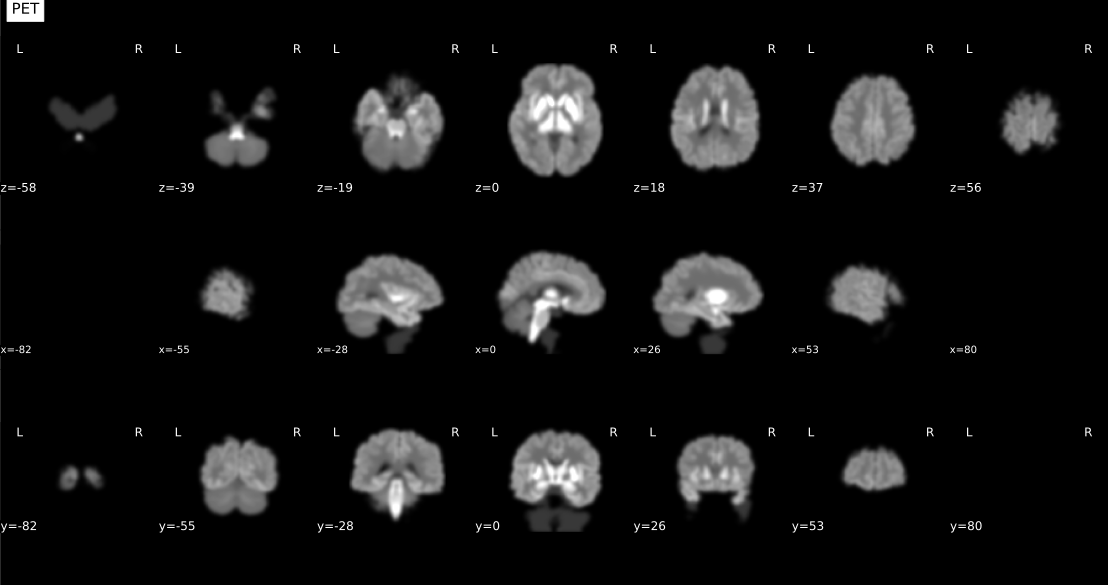

In [10]:
from niworkflows.viz.notebook import display

moving_image = output_path_after
fixed_image = output_path_before
obj = display(
    fixed_image,
    moving_image,
    fixed_label="PET_before",
    moving_label="PET_after",
)

## Motion estimation

We now want to have an estimate of the motion that the model corrects. We will
need to instantiate the `nifreeze.estimator.PETMotionEstimator`, which will
take an instance of the model. We will call `run` to get the parameters of the
affine transform estimation.

In [13]:
from nifreeze.estimator import PETMotionEstimator

estimator = PETMotionEstimator()

# Run the estimator
affines = estimator.run(
    pet_dataset,
    omp_nthreads=4,
)

Estimating PET motion: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [14:09<00:00, 40.45s/it]


In [14]:
affines

[array([[ 0.65869042, -0.05374559, -0.04326331,  7.25648413],
        [-0.08481499,  1.03366097,  0.32393041,  4.54118848],
        [-0.1287729 , -0.02084604,  1.09105762, 10.03369772],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 1.00436190e+00,  1.36685864e-04, -4.30146570e-03,
         -3.45004476e+00],
        [-5.22324196e-03,  9.99752177e-01, -3.40056253e-02,
          2.95459257e+00],
        [ 1.17120503e-02,  2.31347136e-02,  1.02379444e+00,
          5.87092791e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 0.9993597 , -0.02264388, -0.01404295, -8.23041963],
        [ 0.01819538,  1.00262127, -0.02286074,  5.6182289 ],
        [ 0.0120363 ,  0.01949678,  1.00669989,  5.56385759],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 9.93726381e-01, -2.01454338e-03, -6.06226804e-03,
          2.27780692e+00],
        [ 2.44405961e-03,  1.00075068e+00,  1.18664965e-02,
   

Let's now visualize the estimated motion: we will plot the translation and
rotation components in the affine transform for each axis.

In [ ]:
import numpy as np
import pandas as pd

from nifreeze.registration.utils import compute_fd_from_motion, extract_motion_parameters

# Assume `affines` is the list of affine matrices computed earlier
motion_parameters = []

for _idx, affine in enumerate(affines):
    tx, ty, tz, rx, ry, rz = extract_motion_parameters(affine)
    motion_parameters.append([tx, ty, tz, rx, ry, rz])

motion_parameters = np.array(motion_parameters)
estimated_fd = compute_fd_from_motion(motion_parameters)

In [ ]:
# Set up the matplotlib figure
import matplotlib.pyplot as plt

%matplotlib inline

from nifreeze.viz.motion_viz import plot_volumewise_motion

plot_volumewise_motion(np.arange(len(estimated_fd)), motion_parameters)

plt.show()

For the dataset used in this example, we have access to the ground truth motion parameters that were used to corrupt the motion-free dataset. Let's now plot the ground truth motion to enable a visual comparison with the estimated motion.

In [ ]:
from nifreeze.viz.motion_viz import plot_volumewise_motion

%matplotlib inline

motion_gt_fname = (
    DATA_PATH
    / "pet_data"
    / "sub-02"
    / "ses-baseline"
    / "pet"
    / "sub-02_ses-baseline_ground_truth_motion.csv"
)
motion_gt_df = pd.read_csv(motion_gt_fname)

frames = motion_gt_df["frame"].to_numpy()

# Construct motion_params array with shape (n_frames, 6): [trans_x, trans_y, trans_z, rot_x, rot_y, rot_z]
motion_cols = ["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]
motion_params = motion_gt_df[motion_cols].to_numpy()

plot_volumewise_motion(frames, motion_params)

plt.tight_layout()
plt.show()

Let's plot the estimated and the ground truth framewise displacement.

In [18]:
from nifreeze.viz.motion_viz import plot_framewise_displacement

fd = pd.DataFrame({"estimated": estimated_fd, "gt": motion_gt_df["framewise_displacement"].values})
plot_framewise_displacement(fd, labels=["Estimated", "Ground truth"])

plt.show()

/var/folders/0d/tx6_gy7951749z57rjjkkl_m0000gn/T/ipykernel_5538/4292332895.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
